In [1]:
import sys
sys.version

'3.7.5 (default, Nov  7 2019, 10:50:52) \n[GCC 8.3.0]'

# Chapter 9 - Hierarchical Models

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import arviz as az
import matplotlib.pyplot as plt
from matplotlib import cm  # color map
import seaborn as sns
sns.set()
plt.style.use('seaborn-white')
color = '#87ceeb'

from IPython.display import Image
from matplotlib import gridspec


import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from jax import random, numpy as jnp
from jax.random import PRNGKey
_ntrace = 4
numpyro.set_host_device_count(_ntrace)

In [3]:
%load_ext watermark
%watermark -p numpyro,arviz,scipy,numpy,pandas

numpyro: 0.5.0
arviz  : 0.11.0
scipy  : 1.6.0
numpy  : 1.19.5
pandas : 1.2.1



## 9.1 A Single Coin from a Single Mint

In [4]:
# observation: three Heads and 
y = np.zeros(12); 
y[:9] = 1  # Heads
y

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.])

### Posterior via grid-approximation

- Prior: 
    $$
        w \sim Beta(Aw, Bw) \\
        K = 100 \\
        p(\theta, \omega) = Beta(\theta|a(\omega), b(\omega)) Beta(\omega|A_\omega, B_\omega)
    $$
    - Domain of beta() is approximated with grid
- Likelihood:
    $$
        y_i \sim Bernoulli(\theta) \\
        p(y_i | \theta) = \theta^{y_i} (1 - \theta)^{1-y_i}
    $$
- Posterior:
    $$
        p(\theta, \omega| Y) \approx  p(\theta|a, b) p(\omega|A_w, B_w) \prod_{i=1}^n p(y_i|\theta) \\
        = p(\theta, \omega) \prod_{i=1}^n p(y_i|\theta) 
    $$

* The probability densities are all approximated as mass functions at the grid points.

In [5]:
grid = np.linspace(0, 1, 100)

#### Prior Distributioins

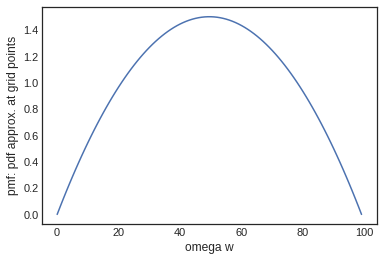

In [6]:
# hyper-prior: prior of prior
Aw, Bw = 2, 2
pdf_w = stats.beta(a=Aw, b=Bw).pdf(grid)

# hyper-prior for K, chosen as a constant 
K = 100

# plot
plt.xlabel('omega w')
plt.ylabel('pmf: pdf approx. at grid points')
plt.plot(pdf_w);

Prior: $\theta$ is determined as a sample from $p(\omega)$

In [7]:
# p(th, w) = p(th|w)p(w)
# p(th|w) = beta(w(K-2)+1, (1-w)(K-2)+1)
pdf_t_given_w = []  # conditionals; arrary of p(th|w) at w's
pdf_tw = []  # joint pdf p(th, w) = p(th|w) * p(w)
for iw, w in enumerate(grid):
    a, b = w*(K-2)+1, (1-w)*(K-2)+1  # (a,b) is determined at (w, K) 
    pdf_t_given_w_at_w = stats.beta(a,b).pdf(grid)
    
    pdf_t_given_w.append(pdf_t_given_w_at_w)
    pdf_tw.append(pdf_t_given_w_at_w * pdf_w[iw])
#
pdf_t_given_w = np.array(pdf_t_given_w) # array of conditionals
#
pdf_tw = np.array(pdf_tw)  # joint prior
pdf_tw /= pdf_tw.sum()

prior = pdf_tw
print(f'# Prior Probability Mass Distribution: {prior.shape}')

# Prior Probability Mass Distribution: (100, 100)


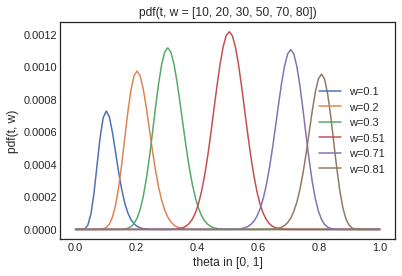

In [8]:
idxs = [10, 20, 30, 50, 70, 80]
for i in idxs:
    plt.plot(grid, pdf_tw[i], label=f'w={grid[i]:.2}')
plt.title(f'pdf(t, w = {idxs})')
plt.xlabel('theta in [0, 1]')
plt.ylabel('pdf(t, w)')
plt.legend();

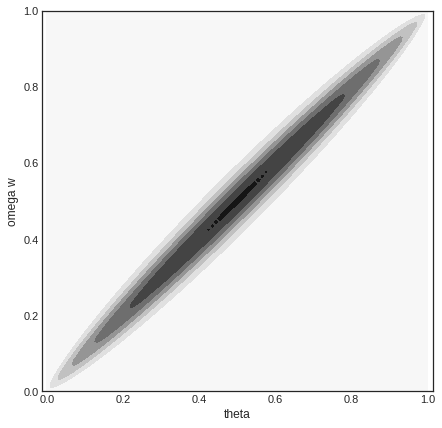

In [9]:
# contour plot of the prior distribution
X, Y = np.meshgrid(grid, grid)
plt.figure(figsize=(7,7))
plt.contourf(X, Y, pdf_tw)
plt.ylabel('omega w')
plt.xlabel('theta')
plt.axis('equal');

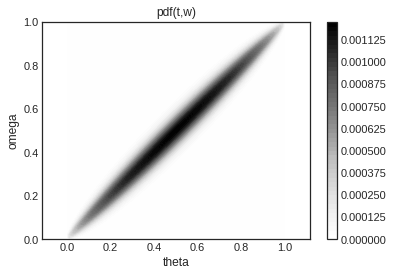

In [10]:
def show3df(Z, title=''):
    plt.contourf(X, Y, Z, 50)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.xlabel('theta')
    plt.ylabel('omega')
    plt.axis('equal');
#
show3df(pdf_tw, title='pdf(t,w)')

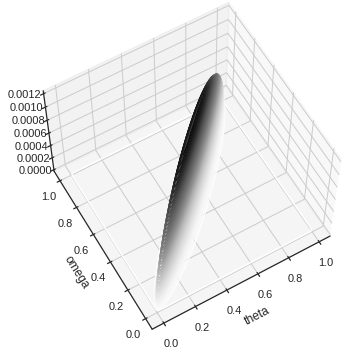

In [11]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, pdf_tw, 50)
ax.set_xlabel('theta')
ax.set_ylabel('omega')
ax.view_init(elev=60, azim=-120)

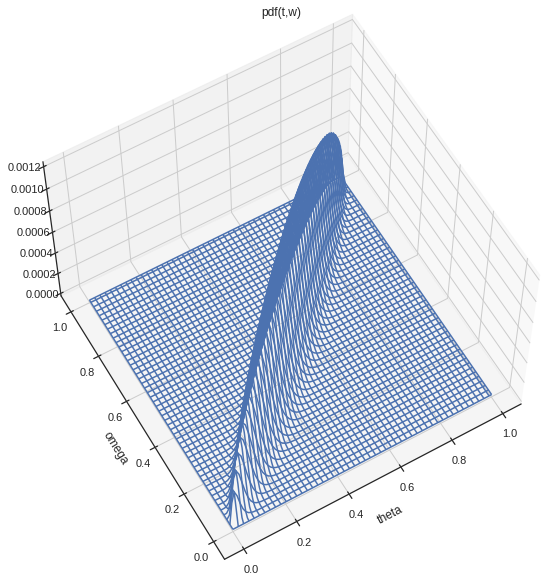

In [12]:
def wf3d(Z, title='', elev=60, azim=-120, fs=10):  # wireframe
    fig = plt.figure(figsize=(fs,fs))
    ax = plt.axes(projection='3d')
    ax.set_title(title if title is not None else 'wireframe')
    ax.plot_wireframe(X, Y, Z)
    ax.set_xlabel('theta')
    ax.set_ylabel('omega')
    ax.view_init(elev=elev, azim=azim)
#
wf3d(pdf_tw, title='pdf(t,w)')

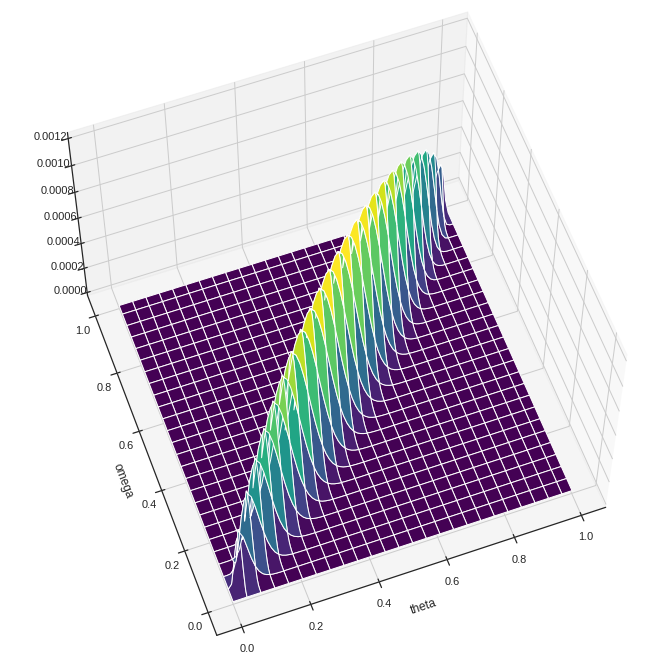

In [13]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, pdf_tw, 
                rstride=4, cstride=4,
                cmap='viridis')
ax.set_xlabel('theta')
ax.set_ylabel('omega')
ax.view_init(elev=60, azim=-110)

#### Likelihood

- Prior: 
    $$
        w \sim Beta(Aw, Bw) \\
        K = 100 \\
        p(\theta, \omega) = Beta(\theta|a(\omega), b(\omega)) Beta(\omega|A_\omega, B_\omega)
    $$
    - Domain of beta() is approximated with grid
- Likelihood:
    $$
        y_i \sim Bernoulli(\theta) \\
        p(y_i | \theta) = \theta^{y_i} (1 - \theta)^{1-y_i}
    $$
- Posterior:
    $$
        p(\theta, \omega| Y) \approx  p(\theta|a, b) p(\omega|A_w, B_w) \prod_{i=1}^n p(y_i|\theta) \\
        = p(\theta, \omega) \prod_{i=1}^n p(y_i|\theta) 
    $$

In [14]:
print(f'y = {y}')
# pmf_y_given_t = 
pdf_y_given_t = np.empty_like(prior)
for i, w in enumerate(pdf_w):
    pdf_t_at_w = pdf_t_given_w[i]
    for j, (t,pt) in enumerate(zip(grid, pdf_t_at_w)):
        p_yi = 1
        for yi in y:
            p_yi *= t if yi else 1-t
        pdf_y_given_t[i][j] = p_yi
    pdf_y_given_t[i] /= pdf_y_given_t[i].sum()
#
likelihood = pdf_y_given_t

y = [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]


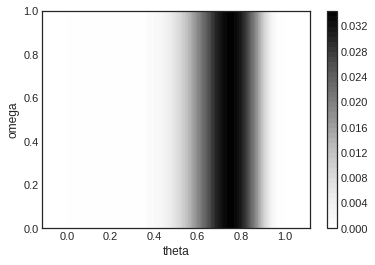

In [15]:
show3df(pdf_y_given_t)

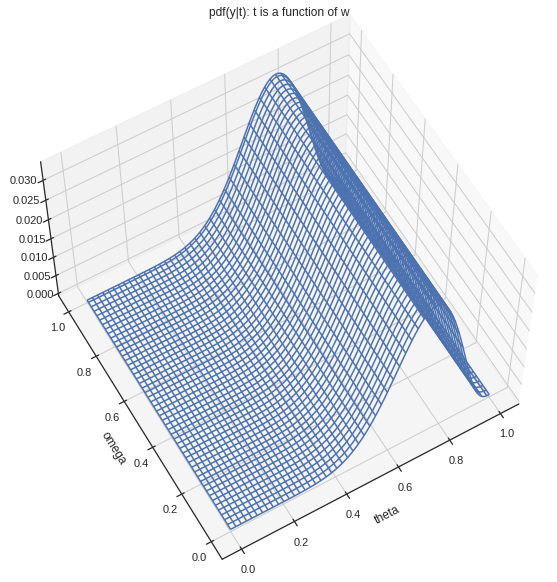

In [16]:
wf3d(pdf_y_given_t, title='pdf(y|t): t is a function of w')

#### Posterior

In [17]:
posterior = prior * likelihood
posterior /= posterior.sum()

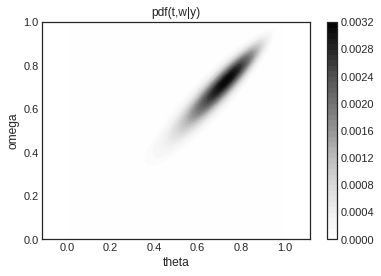

In [18]:
show3df(posterior, title='pdf(t,w|y)')

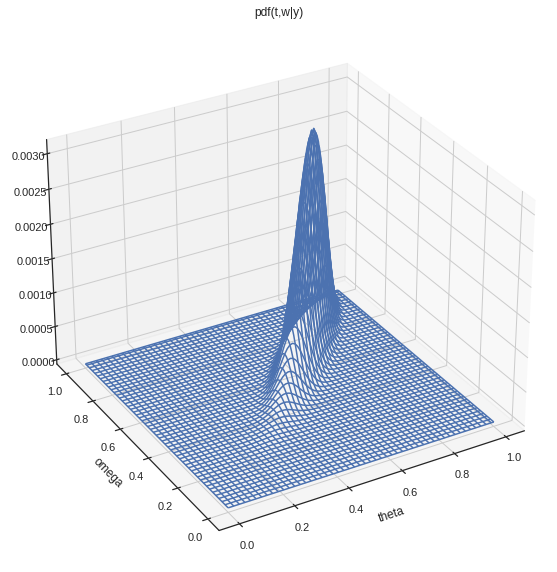

In [19]:
wf3d(posterior, title='pdf(t,w|y)', elev=30)

#### Marginal Posteriors

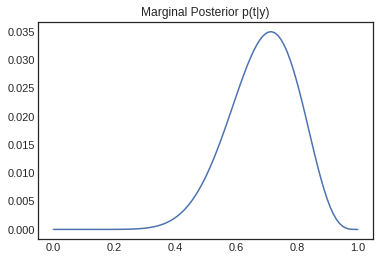

In [20]:
post_t = posterior.sum(axis=0)
plt.plot(grid, post_t)
plt.title('Marginal Posterior p(t|y)');

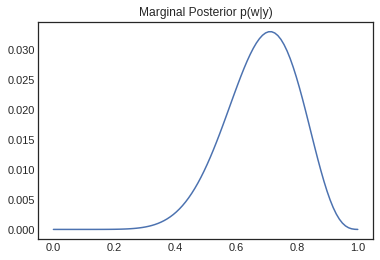

In [21]:
post_w = posterior.sum(axis=1)
plt.plot(grid, post_w)
plt.title('Marginal Posterior p(w|y)');

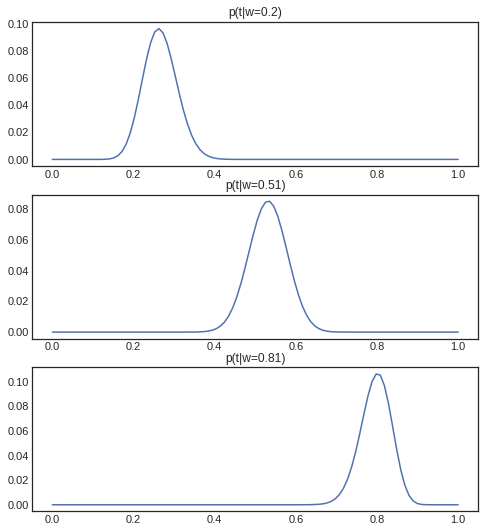

In [22]:
# posteriors, conditional at w=w0

iw0s = [20, 50, 80]
fig, axes = plt.subplots(len(iw0s), 1, figsize=(8, 3*len(iw0s)))
for iw, ax in zip(iw0s, axes.ravel()):
    p_t = posterior[iw]; p_t = p_t / p_t.sum()
    ax.plot(grid, p_t)
    ax.set_title(f'p(t|w={grid[iw]:.2})')
    pass

### Posterior by pyro MCMC

In [23]:
# convenience function
def gomcmc(model, data, num_samples=4000):
    """
    data: dict() type for model function
    """
    mcmc = MCMC(NUTS(model), num_warmup=1500, num_samples=num_samples, num_chains=_ntrace)
    mcmc.run(PRNGKey(0), **data)
    mcmc.print_summary()
    return mcmc

In [24]:
def model(y):
    w = numpyro.sample('w', dist.Beta(Aw, Bw))
    a, b = w*(K-2)+1, (1-w)*(K-2)+1  # (a,b) is determined at (w, K) 
    t = numpyro.sample('t', dist.Beta(a, b))
    with numpyro.plate('iid_obs', len(y)):
        y = numpyro.sample('y', dist.Bernoulli(probs=t), obs=y)
#

In [25]:
%time
data = dict(y=jnp.array(y))
mcmc = gomcmc(model, data, num_samples=5000)
mcmc.print_summary()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         t      0.69      0.11      0.69      0.51      0.87   3804.59      1.00
         w      0.68      0.12      0.69      0.49      0.88   3834.48      1.00

Number of divergences: 0

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         t      0.69      0.11      0.69      0.51      0.87   3804.59      1.00
         w      0.68      0.12      0.69      0.49      0.88   3834.48      1.00

Number of divergences: 0


In [26]:
mcmc.get_samples()['t'].shape

(20000,)

In [27]:
trace = az.from_numpyro(mcmc)

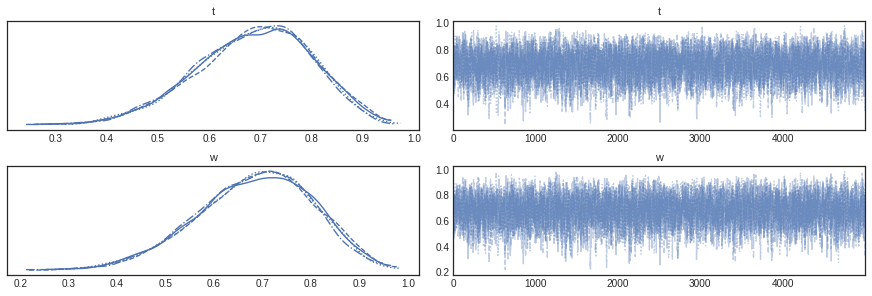

In [28]:
az.plot_trace(trace);

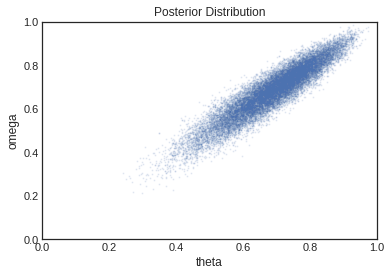

In [29]:
plt.scatter(trace.posterior['t'], trace.posterior['w'], alpha=.1, s=1)
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Posterior Distribution')
plt.xlabel('theta')
plt.ylabel('omega');

### Posterior via pymc3 with MCMC 
- pymc3 does not work wll in Windows 10
- try anaconda if you like

#### Exercise
- Perform expreiments for $K=6$, $A_\omega=20$, $B_\omega=20$.
- Describe how the assumption is different and how the result is different.

## 9.2 Multiple Coins from a Single Mint

- If there are S subjects altogether, then there are S+1 parameters ($t_1, ..., t_S$ and $\omega$) being estimated simultaneously.
- If our primary research interest is the overall effet of the tdrug, not the reactions of individual subjects, then we are most interested in the estimate of $\omega$.

### Posterior via grid approximation

- Suppose we have only two subjects in the same condition (i.e. two coins from the same mint).
- We want to estimate the biases $t_1$ and $t_2$ of the two subjects, and simultaneously estimate $\omega$ of the drug that influenced them.

### A realistic model with MCMC

#### Gamma Distribution
- Two parameters: shape $s$ and rate $r$
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
- https://en.wikipedia.org/wiki/Gamma_distribution

In [30]:
shapes = [0.01, 0.1, 1, 1.5, 2.5, 10]
rates = [0.01, 0.02, 0.1, 0.2, 1]

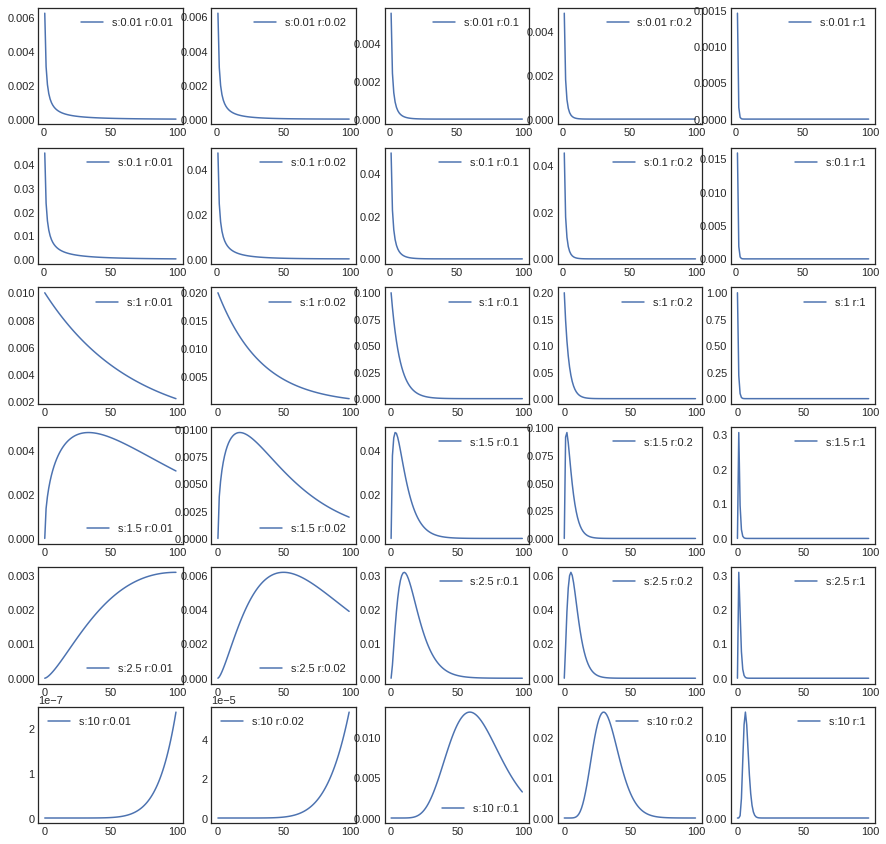

In [31]:
fig, axes = plt.subplots(len(shapes), len(rates), figsize=(15,15))
for i, shape in enumerate(shapes):
    for j, rate in enumerate(rates):
        ax = axes[i, j]
        scale = 1/rate  #
        g = stats.gamma(a=shape, scale=scale)
        x = np.linspace(0, 150, 100)
        ax.plot(g.pdf(x), label=f's:{shape} r:{rate}')
        ax.legend()

- [9.2.4 - Example: Therapeutic touch](#9.2.4---Example:-Therapeutic-touch)   
    - [Shrinkage](#Shrinkage)
- [9.5.1 - Example: Baseball batting abilities by position (subjects within categories)](#9.5.1---Example:-Baseball-batting-abilities-by-position)   

### 9.2.4 - Example: Therapeutic touch

In [32]:
df = pd.read_csv('./data/TherapeuticTouchData.csv', dtype={'s':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   y       280 non-null    int64   
 1   s       280 non-null    category
dtypes: category(1), int64(1)
memory usage: 2.8 KB


In [33]:
df.head()

,y,s
0,1,S01
1,0,S01
2,0,S01
3,0,S01
4,0,S01


#### Figure 9.9

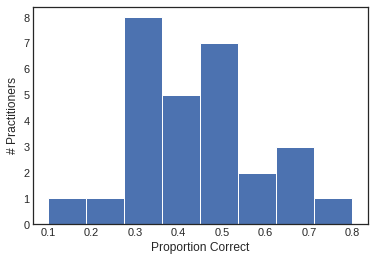

In [34]:
df_proportions = df.groupby('s')['y'].apply(lambda x: x.sum()/len(x))

ax = df_proportions.plot(kind='hist', bins=8)
ax.set(xlabel='Proportion Correct', ylabel='# Practitioners');

#### Model (Kruschke, 2015)

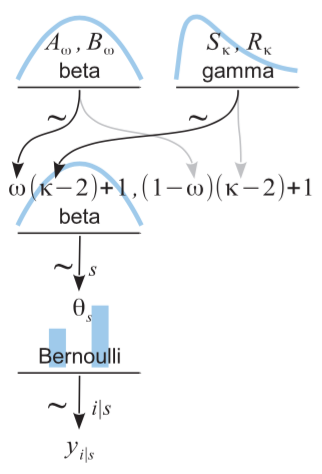

In [35]:
Image('images/fig9_7.png', width=200)

In [40]:
def hierarchical_model(n_theta, theta_inds, y=None):
    """
    ntheta == the number of independent objects
    dim(theta_ids) == dim(y)
    """
    omega = numpyro.sample('omega', dist.Beta(1,1))
    kap_m2 = numpyro.sample('kap_m2', dist.Gamma(0.01, 0.01))
    kappa = numpyro.deterministic('kappa', kap_m2 + 2)
    
    alpha = omega*(kappa-2)+1
    beta = (1-omega)*(kappa-2)+1
    with numpyro.plate('theta_plate', n_theta):
        theta = numpyro.sample('theta', dist.Beta(alpha, beta))

    theta = theta[theta_inds]  # practitioner_idx
    
    with numpyro.plate('observation', len(theta_inds)):
        y = numpyro.sample('y', dist.Bernoulli(probs=theta), obs=y)
        
    return y
#

In [41]:
practitioner_idx = df.s.cat.codes.values
practitioner_codes = df.s.cat.categories
n_practitioners = practitioner_codes.size

data = dict(n_theta=n_practitioners, 
            theta_inds=jnp.array(practitioner_idx), 
            y=jnp.array(df.y.values))

In [42]:
mcmc = gomcmc(hierarchical_model, data, num_samples=5001)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    kap_m2     51.56     52.18     34.38      2.54    112.92   1427.73      1.01
     omega      0.43      0.04      0.44      0.37      0.50   5448.07      1.00
  theta[0]      0.36      0.09      0.37      0.21      0.50   4970.12      1.00
  theta[1]      0.38      0.08      0.39      0.25      0.52   6777.43      1.00
  theta[2]      0.41      0.08      0.41      0.27      0.54  10057.39      1.00
  theta[3]      0.41      0.08      0.41      0.27      0.54  11121.06      1.00
  theta[4]      0.41      0.08      0.41      0.27      0.53  10940.57      1.00
  theta[5]      0.41      0.08      0.41      0.27      0.54  10960.32      1.00
  theta[6]      0.41      0.08      0.41      0.28      0.54  10585.24      1.00
  theta[7]      0.41      0.08      0.41      0.27      0.54  11118.26      1.00
  theta[8]      0.41      0.08      0.41      0.27      0.54  10399.51      1.00
  theta[9]      0.41      0

In [43]:
trace = mcmc.get_samples()
trace

{'kap_m2': DeviceArray([22.572323, 14.003129, 18.431828, ..., 27.05994 , 19.264204,
              44.153   ], dtype=float32),
 'kappa': DeviceArray([24.572323, 16.003128, 20.431828, ..., 29.05994 , 21.264204,
              46.153   ], dtype=float32),
 'omega': DeviceArray([0.406004  , 0.3650618 , 0.43557826, ..., 0.44714165,
              0.4318529 , 0.4031741 ], dtype=float32),
 'theta': DeviceArray([[0.43213615, 0.3993003 , 0.3328976 , ..., 0.44167194,
               0.3849415 , 0.5419014 ],
              [0.20485254, 0.2974959 , 0.24666987, ..., 0.5686195 ,
               0.61569357, 0.5122396 ],
              [0.39437127, 0.33955052, 0.52257997, ..., 0.5512985 ,
               0.4658194 , 0.6366117 ],
              ...,
              [0.47124714, 0.47293484, 0.38411826, ..., 0.5840343 ,
               0.3421824 , 0.5661537 ],
              [0.24962126, 0.2933783 , 0.3964517 , ..., 0.48646757,
               0.64652103, 0.5925791 ],
              [0.28997612, 0.3535606 , 0.49475005,

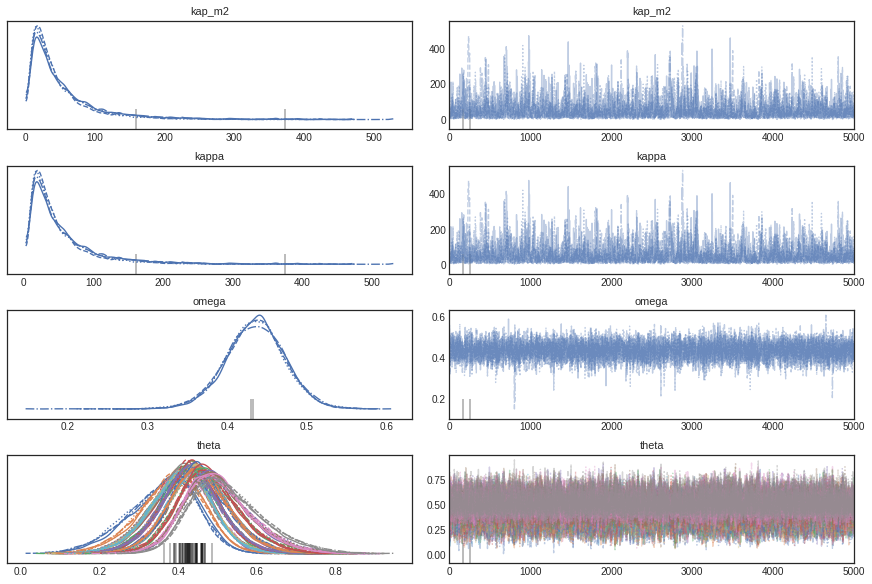

In [44]:
infdata = az.from_numpyro(mcmc)
az.plot_trace(infdata);

#### Figure 9.10 - Marginal posterior distributions

In [45]:
trace = infdata.posterior  #
trace

<xarray.Dataset>
Dimensions:      (chain: 4, draw: 5001, theta_dim_0: 28)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 ... 4995 4996 4997 4998 4999 5000
  * theta_dim_0  (theta_dim_0) int64 0 1 2 3 4 5 6 7 ... 20 21 22 23 24 25 26 27
Data variables:
    kap_m2       (chain, draw) float32 22.57 14.0 18.43 ... 27.06 19.26 44.15
    kappa        (chain, draw) float32 24.57 16.0 20.43 ... 29.06 21.26 46.15
    omega        (chain, draw) float32 0.406 0.3651 0.4356 ... 0.4319 0.4032
    theta        (chain, draw, theta_dim_0) float32 0.4321 0.3993 ... 0.5474
Attributes:
    created_at:                 2021-02-19T01:41:19.008961
    arviz_version:              0.11.0
    inference_library:          numpyro
    inference_library_version:  0.5.0

In [46]:
trace['theta'][:,:,0]

<xarray.DataArray 'theta' (chain: 4, draw: 5001)>
array([[0.43213615, 0.20485254, 0.39437127, ..., 0.4994594 , 0.27793035,
        0.55127203],
       [0.4466533 , 0.40798742, 0.5419758 , ..., 0.4358742 , 0.32009807,
        0.5076283 ],
       [0.3340569 , 0.43178028, 0.2582969 , ..., 0.1838976 , 0.40264583,
        0.35391423],
       [0.3259197 , 0.20007463, 0.22675568, ..., 0.47124714, 0.24962126,
        0.28997612]], dtype=float32)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 ... 4995 4996 4997 4998 4999 5000
    theta_dim_0  int64 0

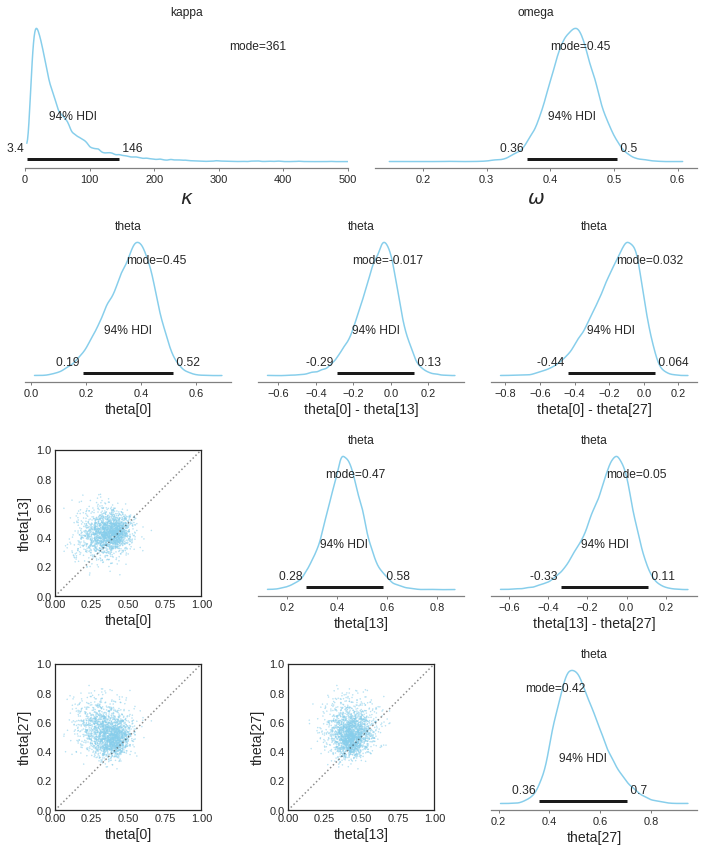

In [47]:
plt.figure(figsize=(10,12))

# Define gridspec
gs = gridspec.GridSpec(4, 6)
ax1 = plt.subplot(gs[0,:3])
ax2 = plt.subplot(gs[0,3:])
ax3 = plt.subplot(gs[1,:2])
ax4 = plt.subplot(gs[1,2:4])
ax5 = plt.subplot(gs[1,4:6])
ax6 = plt.subplot(gs[2,:2])                     
ax7 = plt.subplot(gs[2,2:4])
ax8 = plt.subplot(gs[2,4:6])
ax9 = plt.subplot(gs[3,:2])
ax10 = plt.subplot(gs[3,2:4])
ax11 = plt.subplot(gs[3,4:6])

# thetas and theta pairs to plot
thetas = (0, 13, 27)
theta_pairs = ((0,13),(0,27),(13,27))

font_d = {'size':14}

# kappa & omega posterior plots
for var, ax in zip(['kappa', 'omega'], [ax1, ax2]):
    az.plot_posterior(trace[var], point_estimate='mode', ax=ax, color=color, round_to=2)
    ax.set_xlabel('$\{}$'.format(var), fontdict={'size':20, 'weight':'bold'})
ax1.set(xlim=(0,500))

# theta posterior plots
for var, ax in zip(thetas,[ax3, ax7, ax11]):
    az.plot_posterior(trace['theta'][:,:,var], point_estimate='mode', ax=ax, color=color)
    ax.set_xlabel('theta[{}]'.format(var), fontdict=font_d)

# theta scatter plots
for var, ax in zip(theta_pairs,[ax6, ax9, ax10]):
    ax.scatter(trace['theta'][:,::10,var[0]], trace['theta'][:,::10,var[1]], 
               alpha=0.75, color=color, facecolor='none', s=.2)
    ax.plot([0, 1], [0, 1], ':k', transform=ax.transAxes, alpha=0.5)
    ax.set_xlabel('theta[{}]'.format(var[0]), fontdict=font_d)
    ax.set_ylabel('theta[{}]'.format(var[1]), fontdict=font_d)
    ax.set(xlim=(0,1), ylim=(0,1), aspect='equal')

# theta posterior differences plots
for var, ax in zip(theta_pairs,[ax4, ax5, ax8]):
    az.plot_posterior(trace['theta'][:,:,var[0]]-trace['theta'][:,:,var[1]], point_estimate='mode', ax=ax, color=color)
    ax.set_xlabel('theta[{}] - theta[{}]'.format(*var), fontdict=font_d)

plt.tight_layout()

### Shrinkage

Let's create a model with just the theta estimations per practitioner, without the influence of a higher level distribution. Then we can compare the theta values with the hierarchical model above.

In [48]:
def unpooled_model(n_theta, theta_inds, y=None):
    with numpyro.plate('theta_plate', n_theta):
        theta = numpyro.sample('theta', dist.Beta(1, 1))

    theta = theta[theta_inds]  # practitioner_idx
    
    with numpyro.plate('observation', len(theta_inds)):
        y = numpyro.sample('y', dist.Bernoulli(probs=theta), obs=y)
        
    return y
#

In [49]:
# the same data
data = dict(n_theta=n_practitioners, 
            theta_inds=jnp.array(practitioner_idx), 
            y=jnp.array(df.y.values))

In [50]:
mcmc = gomcmc(unpooled_model, data, num_samples=5001)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.17      0.11      0.15      0.01      0.32  41853.39      1.00
  theta[1]      0.25      0.12      0.24      0.05      0.43  43635.63      1.00
  theta[2]      0.33      0.13      0.32      0.12      0.55  44212.55      1.00
  theta[3]      0.33      0.13      0.32      0.11      0.54  43278.57      1.00
  theta[4]      0.33      0.13      0.32      0.11      0.54  41375.15      1.00
  theta[5]      0.33      0.13      0.32      0.12      0.54  41890.38      1.00
  theta[6]      0.33      0.13      0.32      0.12      0.54  46094.88      1.00
  theta[7]      0.33      0.13      0.32      0.12      0.54  44351.47      1.00
  theta[8]      0.33      0.13      0.32      0.12      0.55  45810.89      1.00
  theta[9]      0.33      0.13      0.32      0.11      0.53  42600.42      1.00
 theta[10]      0.42      0.13      0.41      0.20      0.64  45287.45      1.00
 theta[11]      0.42      0

In [52]:
unpooled_model_inferdata = az.from_numpyro(mcmc)
unpooled_trace = unpooled_model_inferdata.posterior
unpooled_trace

<xarray.Dataset>
Dimensions:      (chain: 4, draw: 5001, theta_dim_0: 28)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 ... 4995 4996 4997 4998 4999 5000
  * theta_dim_0  (theta_dim_0) int64 0 1 2 3 4 5 6 7 ... 20 21 22 23 24 25 26 27
Data variables:
    theta        (chain, draw, theta_dim_0) float32 0.1815 0.1118 ... 0.78 0.619
Attributes:
    created_at:                 2021-02-19T01:41:40.211544
    arviz_version:              0.11.0
    inference_library:          numpyro
    inference_library_version:  0.5.0

In [53]:
az.summary(unpooled_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta[0],0.167,0.105,0.007,0.356,0.001,0.000,41456.0,24117.0,39593.0,12409.0,1.0
theta[1],0.251,0.121,0.043,0.470,0.001,0.001,43859.0,28203.0,43399.0,13605.0,1.0
theta[2],0.334,0.131,0.096,0.574,0.001,0.001,44468.0,31603.0,44618.0,13573.0,1.0
theta[3],0.334,0.133,0.089,0.571,0.001,0.001,43556.0,32806.0,42995.0,13564.0,1.0
theta[4],0.334,0.131,0.105,0.579,0.001,0.001,41680.0,32743.0,40135.0,14521.0,1.0
theta[5],0.333,0.130,0.101,0.573,0.001,0.001,42167.0,31343.0,42105.0,14226.0,1.0
theta[6],0.334,0.131,0.108,0.585,0.001,0.001,46126.0,33876.0,45393.0,14023.0,1.0
theta[7],0.333,0.129,0.097,0.567,0.001,0.000,44441.0,33479.0,43667.0,14215.0,1.0
theta[8],0.333,0.131,0.098,0.575,0.001,0.001,46197.0,33112.0,46554.0,14450.0,1.0
theta[9],0.333,0.130,0.108,0.585,0.001,0.001,42724.0,31469.0,42273.0,13843.0,1.0


Here we concatenate the trace results (thetas) from both models into a dataframe. Next we shape the data into a format that we can use with Seaborn's pointplot.

In [54]:
df_shrinkage = (pd.concat([az.summary(unpooled_trace).iloc[:,0],
                           az.summary(trace).iloc[3:,0]],
                          axis=1)
                .reset_index())
df_shrinkage.columns = ['theta', 'unpooled', 'hierarchical']
df_shrinkage = pd.melt(df_shrinkage, 'theta', ['unpooled', 'hierarchical'], var_name='Model')
df_shrinkage.head()

,theta,Model,value
0,theta[0],unpooled,0.167
1,theta[1],unpooled,0.251
2,theta[2],unpooled,0.334
3,theta[3],unpooled,0.334
4,theta[4],unpooled,0.334


The below plot shows that the theta estimates on practitioner level are pulled towards the group mean of the hierarchical model.

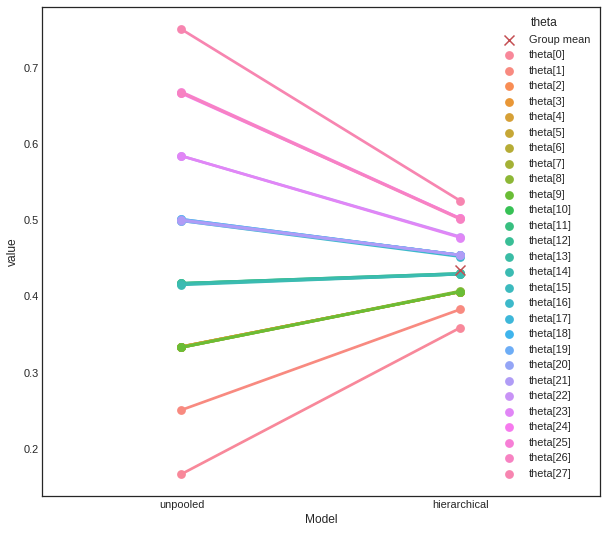

In [55]:
plt.figure(figsize=(10,9))
plt.scatter(1, az.summary(trace)['mean']['omega'], s=100, c='r', marker='x', zorder=999, label='Group mean')
sns.pointplot(x='Model', y='value', hue='theta', data=df_shrinkage);

## 9.5. Extending the Hierarchy: Subjects within categories

### 9.5.1 - Example: Baseball batting abilities by position

In [16]:
df2 = pd.read_csv('data/BattingAverage.csv', usecols=[0,1,2,3], dtype={'PriPos':'category'})
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 4 columns):
Player    948 non-null object
PriPos    948 non-null category
Hits      948 non-null int64
AtBats    948 non-null int64
dtypes: category(1), int64(2), object(1)
memory usage: 23.6+ KB


The DataFrame contains records for 948 players in the 2012 regular season of Major League Baseball.
- One record per player
- 9 primary field positions

In [17]:
df2['BatAv'] = df2.Hits.divide(df2.AtBats)
df2.head(10)

,Player,PriPos,Hits,AtBats,BatAv
0,Fernando Abad,Pitcher,1,7,0.142857
1,Bobby Abreu,Left Field,53,219,0.242009
2,Tony Abreu,2nd Base,18,70,0.257143
3,Dustin Ackley,2nd Base,137,607,0.225700
4,Matt Adams,1st Base,21,86,0.244186
5,Nathan Adcock,Pitcher,0,1,0.000000
6,Jeremy Affeldt,Pitcher,0,1,0.000000
7,Brandon Allen,1st Base,2,20,0.100000
8,Yonder Alonso,1st Base,150,549,0.273224
9,Jose Altuve,2nd Base,167,576,0.289931


In [18]:
# Batting average by primary field positions calculated from the data
df2.groupby('PriPos')['Hits','AtBats'].sum().pipe(lambda x: x.Hits/x.AtBats)

PriPos
1st Base        0.258851
2nd Base        0.255676
3rd Base        0.265036
Catcher         0.247404
Center Field    0.263513
Left Field      0.259077
Pitcher         0.129148
Right Field     0.263555
Shortstop       0.255186
dtype: float64

#### Model (Kruschke, 2015)

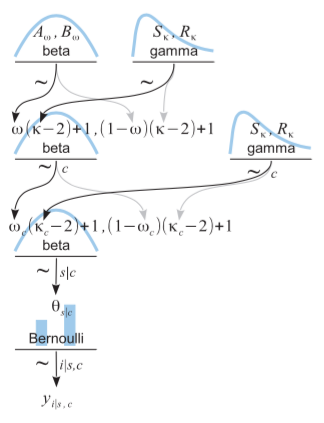

In [19]:
Image('images/fig9_13.png', width=300)

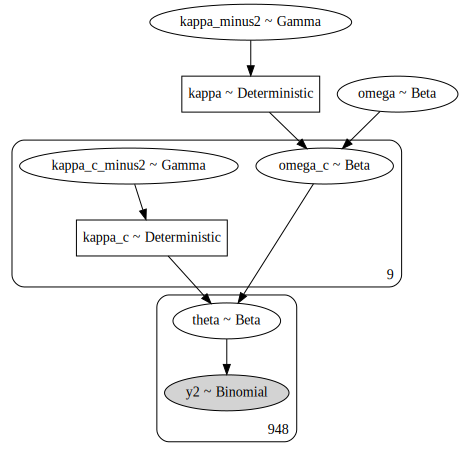

In [20]:
pripos_idx = df2.PriPos.cat.codes.values
pripos_codes = df2.PriPos.cat.categories
n_pripos = pripos_codes.size

# df2 contains one entry per player
n_players = df2.index.size

with pm.Model() as hierarchical_model2:
    # Hyper parameters
    omega = pm.Beta('omega', 1, 1)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    # Parameters for categories (Primary field positions)
    omega_c = pm.Beta('omega_c',
                       omega*(kappa-2)+1, (1-omega)*(kappa-2)+1,
                       shape = n_pripos)
    
    kappa_c_minus2 = pm.Gamma('kappa_c_minus2',
                              0.01, 0.01,
                              shape = n_pripos)
    kappa_c = pm.Deterministic('kappa_c', kappa_c_minus2 + 2)
        
    # Parameter for individual players
    theta = pm.Beta('theta',
                     omega_c[pripos_idx]*(kappa_c[pripos_idx]-2)+1,
                    (1-omega_c[pripos_idx])*(kappa_c[pripos_idx]-2)+1,
                     shape = n_players)
    
    y2 = pm.Binomial('y2', n=df2.AtBats.values, p=theta, observed=df2.Hits)

pm.model_to_graphviz(hierarchical_model2)

In [21]:
with hierarchical_model2:
    trace2 = pm.sample(3000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, kappa_c_minus2, omega_c, kappa_minus2, omega]
Sampling 4 chains: 100%|██████████| 14000/14000 [02:56<00:00, 12.43draws/s] 
The number of effective samples is smaller than 10% for some parameters.


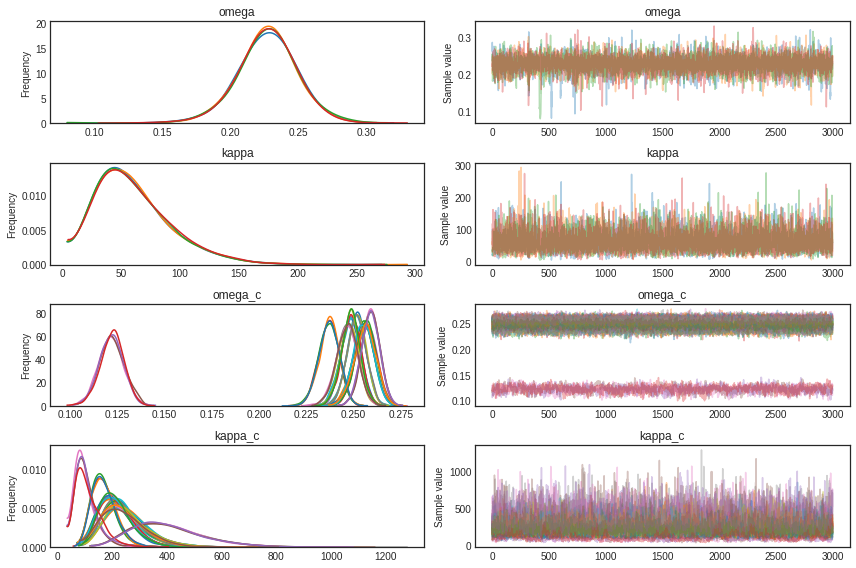

In [22]:
pm.traceplot(trace2, ['omega', 'kappa', 'omega_c', 'kappa_c']);

#### Figure 9.17

#### Posterior distribution of hyper parameter omega after sampling.

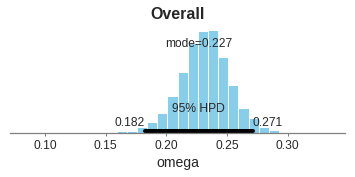

In [23]:
pm.plot_posterior(trace2['omega'], point_estimate='mode', color=color)
plt.title('Overall', fontdict={'fontsize':16, 'fontweight':'bold'})
plt.xlabel('omega', fontdict={'fontsize':14});

#### Posterior distributions of the omega_c parameters after sampling.

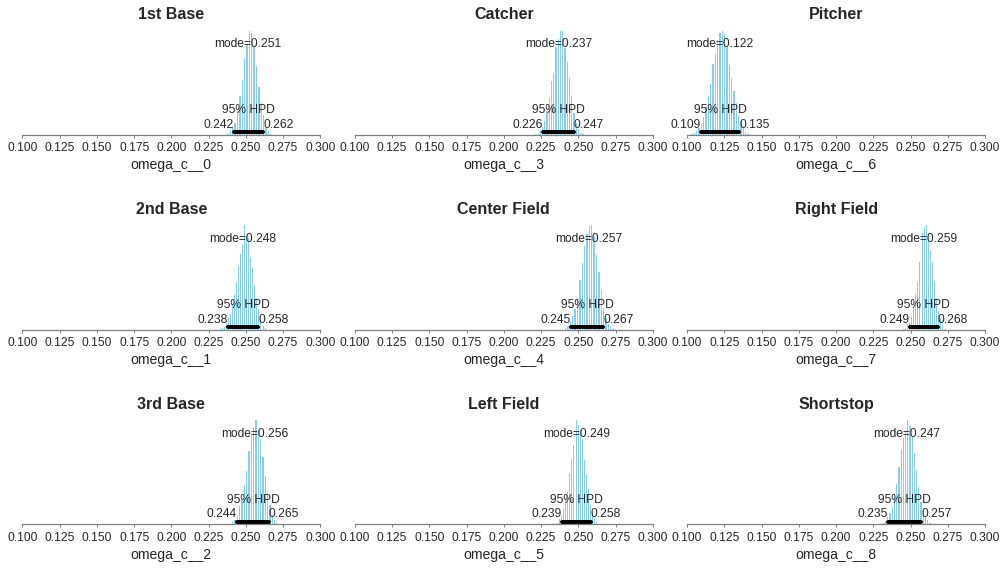

In [24]:
fig, axes = plt.subplots(3,3, figsize=(14,8))

for i, ax in enumerate(axes.T.flatten()):
    pm.plot_posterior(trace2['omega_c'][:,i], ax=ax, point_estimate='mode', color=color)
    ax.set_title(pripos_codes[i], fontdict={'fontsize':16, 'fontweight':'bold'})
    ax.set_xlabel('omega_c__{}'.format(i), fontdict={'fontsize':14})
    ax.set_xlim(0.10,0.30)

plt.tight_layout(h_pad=3)